# Data Import

In [13]:
import pandas as pd
df_nasdaq = pd.read_csv('../data/raw/nasdaq.csv')
df_nasdaq.columns
df_nasdaq.head()


,Label,Ticker,Headline
0,0,A,@TotesTravel : Airline shares tumble as New Yo...
1,1,A,@TotesTravel : American United call off Hong K...
2,0,A,@TotesTravel : U.S. airline stocks hit highest...
3,1,A,@TotesTravel : American Airlines reaches deal ...
4,1,A,@TotesTravel : US airlines Treasury Department...


# Basic data exploration

In [14]:
df_nasdaq[['Label','Ticker','Headline']].isna().sum()

Label       0
Ticker      0
Headline    0
dtype: int64

In [15]:
df_nasdaq[['Label','Ticker','Headline']].duplicated().sum()

np.int64(2631)

### Removing duplicates

In [16]:
df_nasdaq.drop_duplicates().reset_index(drop=True)

,Label,Ticker,Headline
0,0,A,@TotesTravel : Airline shares tumble as New Yo...
1,1,A,@TotesTravel : American United call off Hong K...
2,0,A,@TotesTravel : U.S. airline stocks hit highest...
3,1,A,@TotesTravel : American Airlines reaches deal ...
4,1,A,@TotesTravel : US airlines Treasury Department...
...,...,...,...
10545,1,ZNGA,Bitcoin Tops $1000 Again as Zynga Accepts Virt...
10546,1,ZNGA,Zynga Accepts Bitcoin For Microtransactions
10547,1,ZUMZ,Zumiez (ZUMZ) unusual put activity into earnin...
10548,1,ZUMZ,Zumiez Is Going Bankrupt


### Checking label distribution

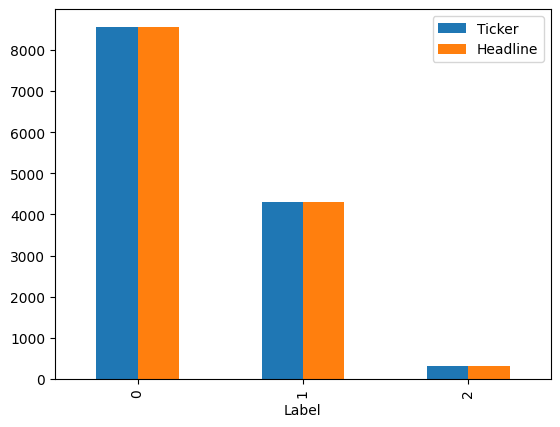

In [6]:
import matplotlib.pyplot as plt
df_nasdaq.groupby(['Label']).count().plot(kind='bar')
plt.show()

### Meaning of labels in dataset
0 -> Stock went down after article
1 -> Stock went up after article
2 -> Stock neutral after article

In [18]:
df_nasdaq['Headline'].str.len().describe()

count    13181.000000
mean       121.272817
std         76.326246
min          2.000000
25%         63.000000
50%         91.000000
75%        177.000000
max        309.000000
Name: Headline, dtype: float64

In [19]:
df_nasdaq[df_nasdaq['Headline'].str.len()<=20]

,Label,Ticker,Headline
590,0,ERIC,DJ Michelle Ericsson
1889,1,A,Dave Cameron fired
1890,0,A,Help Dave!
1914,0,A,SUPER DAVE IS BACK!
1919,1,A,Dave is gay.
...,...,...,...
11920,0,UPWK,Upwork Tests
12422,0,VRM,Vroom Vroom (vid)
12897,0,AXP,XP
13161,0,ZNGA,jual chip zynga


# Zero shot classification
We use a Zero-Shot Classification model (facebook/bart-large-mnli) to evaluate how relevant each news headline is to specific topics related to the stock market.

The model assigns a relevance score (between 0 and 1) for each headline across the following topics:

"stock market"

"finance"

"company news"

"business"

"economy"

"politics"

"entertainment"

If a headline receives a maximum score below 0.20 for all of the above topics, it is considered irrelevant to financial or market-related content.

In [18]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli",device=0)

c:\Users\USER\Desktop\Sentiment_ananalysis\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cuda:0


In [19]:
candidate_labels = ["stock market", "finance", "company news", "business", "economy", "politics", "entertainment"]
headlines = df_nasdaq['Headline'].tolist()
results = classifier(headlines, candidate_labels, batch_size=8) 
df_nasdaq['Highest label'] = [result['labels'][0] for result in results]
df_nasdaq['Highest Score'] = [result['scores'][0] for result in results]

In [23]:
df_nasdaq.head()

,Label,Ticker,Headline,Highest label,Highest Score
0,0,A,@TotesTravel : Airline shares tumble as New Yo...,company news,0.411234
1,1,A,@TotesTravel : American United call off Hong K...,company news,0.493645
2,0,A,@TotesTravel : U.S. airline stocks hit highest...,stock market,0.459379
3,1,A,@TotesTravel : American Airlines reaches deal ...,company news,0.403023
4,1,A,@TotesTravel : US airlines Treasury Department...,company news,0.334893


### Storing dataset with added label scores

In [20]:
df_nasdaq.to_csv('../data/processed/nasdaq_with_labels.csv', index=False)

In [39]:
import pandas as pd
df_nasdaq = pd.read_csv('../data/processed/nasdaq_with_labels.csv')

In [40]:
df_nasdaq[df_nasdaq['Highest Score'] < 0.40]

,Label,Ticker,Headline,Highest label,Highest Score
4,1,A,@TotesTravel : US airlines Treasury Department...,company news,0.334893
6,0,AAPL,European Union regulators who slapped Apple In...,finance,0.376262
7,1,AAPL,The EU's ruling that Apple Inc must pay a huge...,economy,0.284207
20,0,AAPL,India reluctant to give special tax incentives...,business,0.276878
46,0,AAPL,IPhone application development is the developm...,economy,0.319029
...,...,...,...,...,...
13164,1,ZNGA,Zynga Is Now Worth Lesser Than its Own Headqua...,company news,0.305671
13166,1,ZNGA,cheap zynga poker chips,economy,0.374822
13172,0,ZNGA,Anonymous attack of Facebook Zynga looms,company news,0.376847
13176,1,ZNGA,Bitcoin Tops $1000 Again as Zynga Accepts Virt...,finance,0.339270


### Dropping irrelevant headlines
Dropping irrelevant rows which are unwanted results from web scraping where the zero shot classification got very low confidence in above labels

In [41]:
df_nasdaq2 = df_nasdaq[df_nasdaq['Highest Score'] >= 0.40].reset_index(drop=True)

In [42]:
df_nasdaq2[df_nasdaq2['Highest Score'] < 0.40]

,Label,Ticker,Headline,Highest label,Highest Score


In [43]:
df_nasdaq2.count()

Label            7828
Ticker           7828
Headline         7828
Highest label    7828
Highest Score    7828
dtype: int64

# Generating word embeddings
Since ML models can only work with numbers we need to convert each headline and stock name into numerical representation without loosing meaning. So, we convert the Stock names or Stock labels to embeddings using Label Encoder and Headlines using Yiyanghkust/finbert-tone which is trained on financial data making it more relevant for stock headlines.

In [45]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
stock_embeddings = le.fit_transform(df_nasdaq2['Ticker'].tolist())
stock_embeddings = np.array(stock_embeddings).reshape(-1,1)
print(stock_embeddings.shape)


(7828, 1)


In [46]:
from sentence_transformers import SentenceTransformer
import numpy as np
model = SentenceTransformer("yiyanghkust/finbert-tone")
headline_embeddings = model.encode(df_nasdaq2['Headline'].tolist(), show_progress_bar=True)
headline_embeddings = np.array(headline_embeddings)



No sentence-transformers model found with name yiyanghkust/finbert-tone. Creating a new one with mean pooling.
Batches: 100%|██████████| 245/245 [00:40<00:00,  6.03it/s]


Combining both stock name embeddings and headline embeddings to get a final embedding

In [47]:
embeddings = np.concatenate([stock_embeddings, headline_embeddings],axis=1)
print(embeddings.shape)

(7828, 769)


In [ ]:
print(embeddings.shape)  
x = embeddings
y = df_nasdaq2['Label'].tolist()

(7828, 769)


# Test train split

In [49]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# Imbalance handling
As we have observed from above analysis, the data set is imblanced with label 0 (stock down) being the majority and label 2 (stock neutral) being minority so to balance this we are using SMOTE

In [50]:
from imblearn.over_sampling import SMOTE
from collections import Counter
smt = SMOTE()
x_train_sm, y_train_sm = smt.fit_resample(x_train, y_train)
print('Before', Counter(y_train))
print('After', Counter(y_train_sm))


Before Counter({0: 3769, 1: 1983, 2: 119})
After Counter({1: 3769, 0: 3769, 2: 3769})


# Logistic regression with and without using SMOTE

### Without smote:

In [51]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
import joblib
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class='multinomial', class_weight='balanced' ,solver='lbfgs', random_state=42,max_iter=10000)
model.fit(x_train, y_train)


y_pred = model.predict(x_test)
print("Accuracy_score" ,accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(f"[[{cm[0,0]} {cm[0,1]} {cm[0,2]}]")
print(f" [{cm[1,0]} {cm[1,1]} {cm[1,2]}]")
print(f" [{cm[2,0]} {cm[2,1]} {cm[2,2]}]]")

c:\Users\USER\Desktop\Sentiment_ananalysis\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy_score 0.5646397547266224
              precision    recall  f1-score   support

           0       0.71      0.58      0.64      1236
           1       0.44      0.55      0.49       671
           2       0.14      0.28      0.19        50

    accuracy                           0.56      1957
   macro avg       0.43      0.47      0.44      1957
weighted avg       0.60      0.56      0.58      1957

Confusion Matrix:
[[723 458 55]
 [273 368 30]
 [19 17 14]]


### With smote:

In [52]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
import joblib
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class='multinomial', class_weight='balanced' ,solver='lbfgs', random_state=42,max_iter=10000)
model.fit(x_train_sm, y_train_sm)


y_pred = model.predict(x_test)
print("Accuracy_score" ,accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(f"[[{cm[0,0]} {cm[0,1]} {cm[0,2]}]")
print(f" [{cm[1,0]} {cm[1,1]} {cm[1,2]}]")
print(f" [{cm[2,0]} {cm[2,1]} {cm[2,2]}]]")

c:\Users\USER\Desktop\Sentiment_ananalysis\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy_score 0.5666836995401124
              precision    recall  f1-score   support

           0       0.71      0.60      0.65      1236
           1       0.43      0.52      0.47       671
           2       0.15      0.28      0.19        50

    accuracy                           0.57      1957
   macro avg       0.43      0.47      0.44      1957
weighted avg       0.60      0.57      0.58      1957

Confusion Matrix:
[[747 439 50]
 [293 348 30]
 [18 18 14]]


# Random forest with and without SMOTE

### Using smote:

In [53]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, class_weight = 'balanced' ,random_state=42)
rf_model.fit(x_train_sm, y_train_sm)
y_pred = rf_model.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(f"[[{cm[0,0]} {cm[0,1]} {cm[0,2]}]")
print(f" [{cm[1,0]} {cm[1,1]} {cm[1,2]}]")
print(f" [{cm[2,0]} {cm[2,1]} {cm[2,2]}]]")

Accuracy: 0.7072049054675523
              precision    recall  f1-score   support

           0       0.74      0.85      0.79      1236
           1       0.63      0.47      0.54       671
           2       0.74      0.28      0.41        50

    accuracy                           0.71      1957
   macro avg       0.70      0.54      0.58      1957
weighted avg       0.70      0.71      0.69      1957

Confusion Matrix:
[[1052 183 1]
 [349 318 4]
 [29 7 14]]


### Without smote:

In [54]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, class_weight = 'balanced' ,random_state=42)
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(f"[[{cm[0,0]} {cm[0,1]} {cm[0,2]}]")
print(f" [{cm[1,0]} {cm[1,1]} {cm[1,2]}]")
print(f" [{cm[2,0]} {cm[2,1]} {cm[2,2]}]]")

Accuracy: 0.7291773122125702
              precision    recall  f1-score   support

           0       0.72      0.95      0.82      1236
           1       0.80      0.35      0.49       671
           2       0.72      0.26      0.38        50

    accuracy                           0.73      1957
   macro avg       0.75      0.52      0.56      1957
weighted avg       0.74      0.73      0.69      1957

Confusion Matrix:
[[1178 57 1]
 [431 236 4]
 [34 3 13]]


# Xgboost with and without SMOTE

### With smote:

In [55]:
from xgboost import XGBClassifier
bst = XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05, objective='multi:softmax',num_class=3)
bst.fit(x_train_sm, y_train_sm)
y_pred = bst.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(f"[[{cm[0,0]} {cm[0,1]} {cm[0,2]}]")
print(f" [{cm[1,0]} {cm[1,1]} {cm[1,2]}]")
print(f" [{cm[2,0]} {cm[2,1]} {cm[2,2]}]]")

Accuracy: 0.7184466019417476
              precision    recall  f1-score   support

           0       0.75      0.84      0.80      1236
           1       0.64      0.52      0.57       671
           2       0.67      0.32      0.43        50

    accuracy                           0.72      1957
   macro avg       0.68      0.56      0.60      1957
weighted avg       0.71      0.72      0.71      1957

Confusion Matrix:
[[1044 189 3]
 [320 346 5]
 [26 8 16]]


### Without smote:

In [56]:
import numpy as np
from xgboost import XGBClassifier
bst = XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05, objective='multi:softmax',num_class=3)
bst.fit(x_train, y_train)
y_pred = bst.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(f"[[{cm[0,0]} {cm[0,1]} {cm[0,2]}]")
print(f" [{cm[1,0]} {cm[1,1]} {cm[1,2]}]")
print(f" [{cm[2,0]} {cm[2,1]} {cm[2,2]}]]")

Accuracy: 0.7230454777721002
              precision    recall  f1-score   support

           0       0.72      0.92      0.81      1236
           1       0.71      0.41      0.52       671
           2       1.00      0.24      0.39        50

    accuracy                           0.72      1957
   macro avg       0.81      0.52      0.57      1957
weighted avg       0.73      0.72      0.70      1957

Confusion Matrix:
[[1131 105 0]
 [399 272 0]
 [32 6 12]]


# Conclusion
We experimented with three machine learning models to predict stock price movement based on news headlines:
1. Logistic Regression
2. Random Forest Classifier
3. XGBoost Classifier

Each model was trained with and without SMOTE (Synthetic Minority Oversampling Technique) to address class imbalance. 
Based on the above analysis, the best-performing model was selected for deployment.
A Python script was then developed to allow users to input a headline and a stock name, after which the model predicts the relevance or category of the headline.